In [6]:
import glm_utils.preprocessing, glm_utils.bases
import sklearn.linear_model
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, binned_statistic
import pickle
import pandas as pd
import seaborn as sns
from DN_tools import load_into_pandas, bases_dict, load_recording, get_xy, chunked_test_train_split, plot_glm_filter
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

import os
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, ttest_rel, wilcoxon

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")

# Helping functions

In [53]:
def convert_pvalue_to_asterisks(pv_list, explicit=False):
    from collections import OrderedDict
    pv_asterisks = OrderedDict(sorted({0.05:'*',0.01:'**',0.001:'***'}.items()))

    pv_strings = []
    for pv in pv_list:
        if np.isnan(pv) or (pv > 0.05):
            if not explicit:
                pv_strings.append('ns')
            else:
                pv_strings.append(f'{pv:.3f}')
        else:
            for key, pvstr in pv_asterisks.items():
                if pv < key:
                    pv_strings.append(pvstr)
                    break
    return pv_strings

def add_pv_extra_explicit(p_array,data_rpi,hierarchy_levels=[],pairs_tested=None,hierarchy_shift=0.075,pv_marker_width=0.01,pv_line_min=1.0,ax=None,data_xpos=None,numbers_fontsize=7,line_lw=1,padding=0.1,explicit_pvs=False,explicit_ns=True,asterisk_fontsize=10,ignore_ns=True):
    data_xpos = np.arange(len(data_rpi)) if data_xpos is None else data_xpos
    ax = plt.gca() if ax is None else ax
    pairs_tested = [[2*ii,2*ii+1] for ii in range(int(len(data_rpi)/2))] if pairs_tested is None else pairs_tested
    hierarchy_levels = np.arange(len(pairs_tested)) if len(hierarchy_levels)==0 else hierarchy_levels
    
    if explicit_pvs:
        p_array = np.clip(p_array,0,1)
        pv_strings = [f"p={pp:.1e}".replace("e-0", "e-") if pp < 0.005 else f"p={pp:.2f}" for pp in p_array]
        if not explicit_ns:
            pv_strings = [pvs if pp < 0.05 else 'ns' for pp, pvs in zip(p_array,pv_strings)]
        color_list = ['k' if pp < 0.05 else 'grey' for pp in p_array]
        fontsize_list = [numbers_fontsize]*len(pv_strings)
    else:
        pv_strings = convert_pvalue_to_asterisks(p_array, explicit=explicit_ns)
        color_list = ['k' if '*' in pvstr else 'grey' for pvstr in pv_strings]
        if not explicit_ns:
            pv_strings = [pvs if pp < 0.05 else 'ns' for pp, pvs in zip(p_array,pv_strings)]
        fontsize_list = [asterisk_fontsize if '*' in pvstr else numbers_fontsize for pvstr in pv_strings]

    if ignore_ns:
        should_be_plot = [pp < 0.05 for pp in p_array]
    else:
        should_be_plot = [True]*len(p_array)

    for bp, pv, cc, hlevel, text_fontsize, plot_condition in zip(pairs_tested, pv_strings, color_list, hierarchy_levels, fontsize_list, should_be_plot):
        if plot_condition:
            baseline = hlevel*hierarchy_shift+pv_line_min

            if '*' in pv:
                text_pad = -5*pv_marker_width
            else:
                text_pad = pv_marker_width
            ax.plot([data_xpos[bp[0]]+padding,data_xpos[bp[0]]+padding,data_xpos[bp[1]]-padding,data_xpos[bp[1]]-padding], [baseline, baseline+pv_marker_width, baseline+pv_marker_width, baseline], lw=line_lw, color=cc, zorder=1)
            ax.text(np.mean(data_xpos[list(bp)]), baseline+text_pad, pv, color=cc, size=text_fontsize, horizontalalignment='center', verticalalignment='bottom', bbox={'facecolor':'none', 'linewidth':0, 'alpha':1}, zorder=-1)
    
def _plot_bars(ax, df_plot, xlabel, ylims, color_palette, stripcolor_palette=['#666666'], marker_color='k', alpha_stripplot=1):
    sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=color_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 10, "markeredgecolor": marker_color, "markerfacecolor": marker_color, "linewidth": 5}, medianprops={"visible": False}, width=0.5)
    sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)

    ax.set_xticks(ax.get_xticks(), [boxplot_label_dict[varname] for varname in variables_list], rotation=0, ha='center',va='center',fontsize=8)
    ax.tick_params(axis='x', which='major', length=0) # hides ticks without hiding ticklabel
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Performance',fontsize=8)
    trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-0.25, (ylims[1]-ylims[0])/2,transform=trans)

def _plot_bars_DM(ax, df_plot, xlabel, ylims, boxcolor_palette, alpha_stripplot, stripcolor_palette=['#666666']):

    hue_order=['left','right']

    # sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=boxcolor_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
    sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=boxcolor_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8}, meanprops={"visible": False}, width=0.75) #, medianprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5})

    # Overwrite each box color manually
    for i, patch in enumerate(ax.patches[:8]):
        patch.set_facecolor(boxcolor_palette[i])

    # color mean lines of boxplots according to hue
    mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
    for i, line in enumerate(mean_lines):
        if (i == 4 or i == 5) or (i == 0 or i == 1):
            line.set_markerfacecolor('k')
            line.set_markeredgecolor('k')
        elif (i == 2 or i == 3) or (i == 6 or i == 7):
            line.set_markerfacecolor('w')
            line.set_markeredgecolor('w')

    sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=True,legend=False, size=2, edgecolor='none', linewidth=0.5)

    ax.set_xticks(ax.get_xticks(), [boxplot_label_dict[varname] for varname in variables_list], rotation=0, ha='center',va='center',fontsize=8)
    ax.tick_params(axis='x', which='major', length=0) # hides ticks without hiding ticklabel
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Performance',fontsize=8)
    trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-0.25, (ylims[1]-ylims[0])/2,transform=trans)

# General parameters and variables

In [8]:
# data paths (TO BE CHANGED)
raw_data_dir_path = 'W:/apalaci/code/janache' # TO BE CHANGED TO LOCATION OF RAW DATA
datefolder = '../res/models' # TO BE CHANGED TO LOCATION OF RESULTS DATA
neuron_list =['DN_SPEEDO','MDN','real_DNp17','imposter']  # TO BE CHANGED TO NAME OF NEURONS ACCORDING TO DATA FOLDERS AND INFO TABLES

# fixed color and label parameters (TODO: likely overwritten)
color_perside_dict = {'MDN':'#164CA0','MDN undefined':'#164CA0','imposter left':'#D83288','imposter right':'k', 'DopaMeander left':'#D83288','DopaMeander right':'k','DNp17':'goldenrod','Roadrunner':'SeaGreen'} # probably overwritten at the moment
color_perDN_dict = {'MDN':'#164CA0','imposter':'#D83288','DopaMeander':'#D83288','DNp17':'goldenrod','Roadrunner':'SeaGreen'} # probably overwritten at the moment
labels_dict = {'v_fwd':r'$v_{fwd}$','v_ang':r'$v_{ang}$','abs_v_fwd':r'$|v_{fwd}|$','abs_v_ang':r'$|v_{ang}|$','pos_v_fwd':r'$v_{fwd}^+$','pos_v_ang':r'$v_{ang}^+$','neg_v_fwd':r'$v_{fwd}^-$','neg_v_ang':r'$v_{ang}^-$'} # probably overwritten at the moment

# load experiment table
df = load_into_pandas(dir_path=raw_data_dir_path)
df = df[(df.to_ignore == False)&(df.DN.isin(neuron_list))].reset_index(drop=True)
df.loc[df.DN == 'imposter','DN'] = 'DopaMeander'

# other plotting parameters
first_time = True
cm = 1/2.54
figsize_unit = 3*cm

# downsampling parameters
sample_frequency = 20000
bin_width = 100
decimating_values = [10,10] # product must equal bin_width !
subsampled_frequency = int(sample_frequency/bin_width)

# chunk parameters
block_size = 5_000
n_block_min=5

# test-train split 
test_size = 0.35

# random seed
random_state = 42

# starting number of bins for nonlinear estimation
starting_nbins = 32

# GLM window size (number of downsampled bins: for bin_width 100 and sample_frequency 20000, downsampled bin = 5ms, thus window 600 = 3s)
window = 600

# labels and colors for boxplots of panels D,F,H,J      DMR_colors and DML_colors may be overwritten already
boxplot_label_dict = {'v_fwd':'raw','abs_v_fwd':'abs','pos_v_fwd':'fwd','neg_v_fwd':'bwd','v_ang':'raw','abs_v_ang':'abs','pos_v_ang':'left','neg_v_ang':'right'}
MDN_colors = {'v_fwd': "#0DD7D7", 'abs_v_fwd': "#164CA0", 'pos_v_fwd': "#0DD7D7", 'neg_v_fwd': "#164CA0",'v_ang': "#0DD7D7", 'abs_v_ang': "#164CA0", 'pos_v_ang': "#0DD7D7", 'neg_v_ang': "#164CA0"}
DML_colors = {'v_fwd': "#D83288", 'abs_v_fwd': "#630039", 'pos_v_fwd': "#D83288", 'neg_v_fwd': "#630039",'v_ang': "#D83288", 'abs_v_ang': "#630039", 'pos_v_ang': "#D83288", 'neg_v_ang': "#630039"}
DMR_colors = {'v_fwd': "k", 'abs_v_fwd': "grey", 'pos_v_fwd': "k", 'neg_v_fwd': "grey",'v_ang': "k", 'abs_v_ang': "grey", 'pos_v_ang': "k", 'neg_v_ang': "grey"}

# Fig 6

## Panel A (illustration)

In [9]:
plot_options = {'rowindex': 38,'varname': 'abs_v_fwd','ylims': [0,6],'yticklabels': [0,6],'xlims': [176,181],'ylabel': r'$|v_{fwd}|$ (mm/s)','filt_ylim': [0,0.5],'NL_lims': [0,1]} # should correspond to abs_v_fwd 2024_11_29_0005 imposter now called DopaMeander

rowindex = plot_options['rowindex']
varname = plot_options['varname']
ylims = plot_options['ylims']
yticklabels = plot_options['yticklabels']
xlims = plot_options['xlims']
ylabel = plot_options['ylabel']
filt_ylim = plot_options['filt_ylim']
NL_lims = plot_options['NL_lims']

varname_bins = np.linspace(-2,5,100)
window = int(3*subsampled_frequency)
T = np.arange(-window, 0)/subsampled_frequency
xticklabels = [0,int(xlims[-1]-xlims[0])]

if first_time: # to avoid re-running, since it takes 40s each time otherwise
    B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
    B = B[-window:]
    basis_projection = glm_utils.preprocessing.BasisProjection(B)

    filename, csv_path, DN_type = df.iloc[rowindex][['filename','abs_file_path','DN']]
    print(DN_type, varname, filename)
    singleDN_df = load_recording(csv_path=csv_path)
    x, ys = get_xy(singleDN_df,[varname])

    time = np.arange(0,len(singleDN_df['v_fwd']))/sample_frequency
    time_raw = np.arange(len(singleDN_df['spike']))/sample_frequency
    time_model = time_raw[::bin_width] - (bin_width/(2*sample_frequency))
    raw_time = time_model[window:]

    X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
    X_b = basis_projection.transform(X)

    X_train, X_test, y_train, y_test = chunked_test_train_split(X_b,y_m,block_size=block_size,n_block_min=n_block_min,test_size=test_size,random_state=random_state)

    # Fit
    lr = sklearn.linear_model.LassoCV(max_iter=20000)
    lr.fit(X_train, y_train[:,0])

    # Predictions
    y_pred = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    # Attempt to estimate nonlinearity (last record: ~12% constant value)
    nbins = starting_nbins
    not_finished = True
    while (nbins != 5) and not_finished:
        bin_edges_quantilebased = np.quantile(y_pred, np.linspace(0, 1, nbins + 1))
        try:
            statistic, bin_edges, binnumber = binned_statistic(y_pred, y_train[:,0], statistic='mean', bins=bin_edges_quantilebased, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            constant_input = False
            not_finished = False
        except ValueError as e:
            if str(e) != 'The smallest edge difference is numerically 0.':
                print("ValueError: ",e)
            else:
                nbins -= 1

    if (nbins == 5) and not_finished:
        statistic = [np.nanmean(y_train[:,0])]
        bin_centers = [np.nanmean(y_pred)]
        constant_input = True

    if np.sum(np.isnan(statistic)) > 0:
        y_pred_test_nl = np.interp(y_pred_test, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
    else:
        y_pred_test_nl = np.interp(y_pred_test, bin_centers, statistic)

    # Filter
    basis_weights = lr.coef_
    estimated_filters = basis_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1,window))

    y_pred_full = lr.predict(X_b)
    y_pred_full_nl = y_pred_full + np.interp(y_pred_full, bin_centers, statistic)

    if len(bin_centers)>1:
        nonlinearity_estimate = np.interp(varname_bins, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
        nonlinearity_estimate[ varname_bins > bin_centers[~np.isnan(statistic)].max() ] = np.nan
        nonlinearity_estimate[ varname_bins < bin_centers[~np.isnan(statistic)].min() ] = np.nan
    else:
        nonlinearity_estimate = np.interp(varname_bins, bin_centers, statistic)
    nonlinearity_estimate = nonlinearity_estimate + varname_bins
    
    first_time = False

DopaMeander abs_v_fwd 2024_10_18_0022


C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\551746113.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../fig/fig6_panelA.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


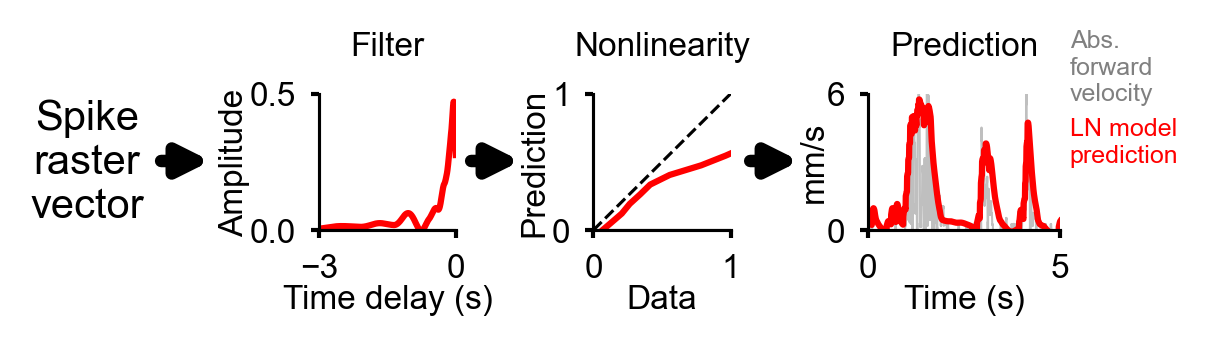

In [10]:
height_ratios = [1]
wspace = 1
width_ratios = [0.5+wspace/4, 1+wspace/4, 1+wspace/4, 1.5+wspace/4]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace)
lw = 1.5

fig,axes = plt.subplots(1,4,figsize=[(sum(width_ratios)+2*wspace)*figsize_unit/2,figsize_unit/2],dpi=300,layout='tight',gridspec_kw=gs_kw)

ax=axes[0]
ax.axis("off")
ax.text(-0.15,0.5,'Spike\nraster\nvector',va='center',ha='center',fontsize=10)

ax=axes[1]
ax.plot(T, estimated_filters[0,:], color='r',lw=lw)
ax.axhline(y=0,color='k',lw=0.5)
ax.set_ylim(filt_ylim)
ax.set_yticks(filt_ylim)
ax.set_xticks([0,-3])
ax.set_ylabel('Amplitude')
ax.yaxis.set_label_coords(-0.5, 0.5)
ax.set_xlabel('Time delay (s)',labelpad=0)
ax.set_title('Filter',y=1.1,fontsize=8)

ax=axes[2]
ax.plot(nonlinearity_estimate,varname_bins, lw=lw, color='r')
ax.axvline(0, c='k',lw=0.5)
ax.axhline(0, c='k',lw=0.5)
ax.plot(NL_lims, NL_lims, linestyle='--',lw=0.75,color='k')
ax.set_xlim(NL_lims)
ax.set_ylim(NL_lims)
ax.set_xticks(NL_lims)
ax.set_yticks(NL_lims)
ax.set_title('Nonlinearity',y=1.1,fontsize=8)
ax.set_xlabel('Data',labelpad=0)
ax.set_ylabel('Prediction',labelpad=0)
ax.yaxis.set_label_coords(-0.31, 0.5)

ax=axes[3]
ax.plot(raw_time, y_m, lw=0.5, alpha=0.25, color='k', label='data')
ax.plot(time_model[window:], y_pred_full_nl, lw=lw, color='r', label='LN prediction')
ax.text(1.05,0.95,"Abs.\nforward\nvelocity", color='gray', fontsize=6, transform=ax.transAxes)
ax.text(1.05,0.5,"LN model\nprediction", color='r', fontsize=6, transform=ax.transAxes)
ax.set_xlim(xlims)
ax.set_xticks(xlims,xticklabels)
ax.set_ylim(ylims)
ax.set_yticks(ylims,yticklabels)
ax.set_xlabel('Time (s)',labelpad=0)
ax.set_ylabel('mm/s')
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_title('Prediction',y=1.1,fontsize=8)

for x in [0.175, 0.425, 0.65]:
    arrow = mpl.patches.ConnectionPatch(
        (x,0.5),
        (x+0.04,0.5),
        coordsA=fig.transFigure,
        coordsB=fig.transFigure,
        color="black",
        arrowstyle="-|>",  # "normal" arrow
        mutation_scale=15,  # controls arrow head size
        linewidth=3,
        transform=fig.transFigure
    )
    fig.patches.append(arrow)

plt.savefig(f'../fig/fig6_panelA.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

## Panel C (boxplot with DNp17)

C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\226622203.py:32: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=1,dodge=True,legend=False, size=2, edgecolor='none')
C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\226622203.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../fig/fig6_panelC.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


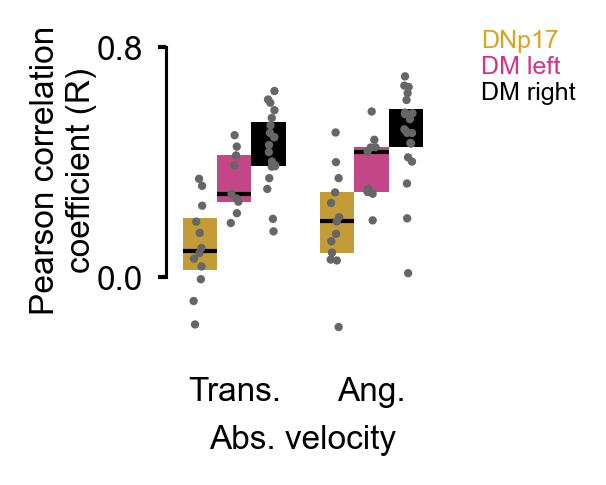

In [51]:
# load table of model performances (generated by analysis.ipynb)
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[~((df_plot.DN == 'DopaMeander') & (df_plot.DN_side == 'undefined'))].copy().reset_index(drop=True)
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']

# plot parameters
plot_variables_list = ['abs_v_fwd','abs_v_ang']
plot_variables_labels =  ['Trans.','Ang.']
DN_list_order = ['DNp17','DopaMeander left','DopaMeander right']
ylims=[0,0.8]
height_ratios = [1]
width_ratios = [1]
wspace = 0.2
hspace = 0.2
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# plot
fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

# sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"visible": False}, width=0.75) #, medianprops={"visible":True,"marker": "_","linewidth": 1})

# change color of mean lines for black groups
mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
for i, line in enumerate(mean_lines):
    if i>3:
        line.set_markerfacecolor('w')
        line.set_markeredgecolor('w')

# individual points
sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=1,dodge=True,legend=False, size=2, edgecolor='none')

# ticks, labels and limits
ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='center',fontsize=8)
ax.tick_params(axis='x', which='major', length=0)
ax.set_yticks(ylims)
ax.set_xlabel('Abs. velocity')
ax.set_ylabel('Performance',fontsize=8)
trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-0.25, (ylims[1]-ylims[0])/2,transform=trans)
ax.spines['bottom'].set_visible(False)
ax.set_ylim([ylims[0]-0.15,ylims[1]])
ax.spines[['left']].set_bounds(ylims)
ax.spines['bottom'].set_position(('outward', 10))

# manual legend
for iDN, DN, DNname in zip(range(3), DN_list_order, ['DNp17','DM left', 'DM right']):
    ax.text(1.8,0.8-iDN*0.09,DNname,color=color_perside_dict[DN],fontsize=6)

# Fix for overlapping/occluded points in the negative values
for o in fig.findobj():
    o.set_clip_on(False)


ax.set_ylabel('Pearson correlation\ncoefficient (R)')
ax.yaxis.set_label_coords(-0.25, 0.55)

plt.savefig(f'../fig/fig6_panelC.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

## Panels E,G,I,K (filters)

v_fwd


C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\3139880473.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../fig/fig6_filters_{veltype}.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


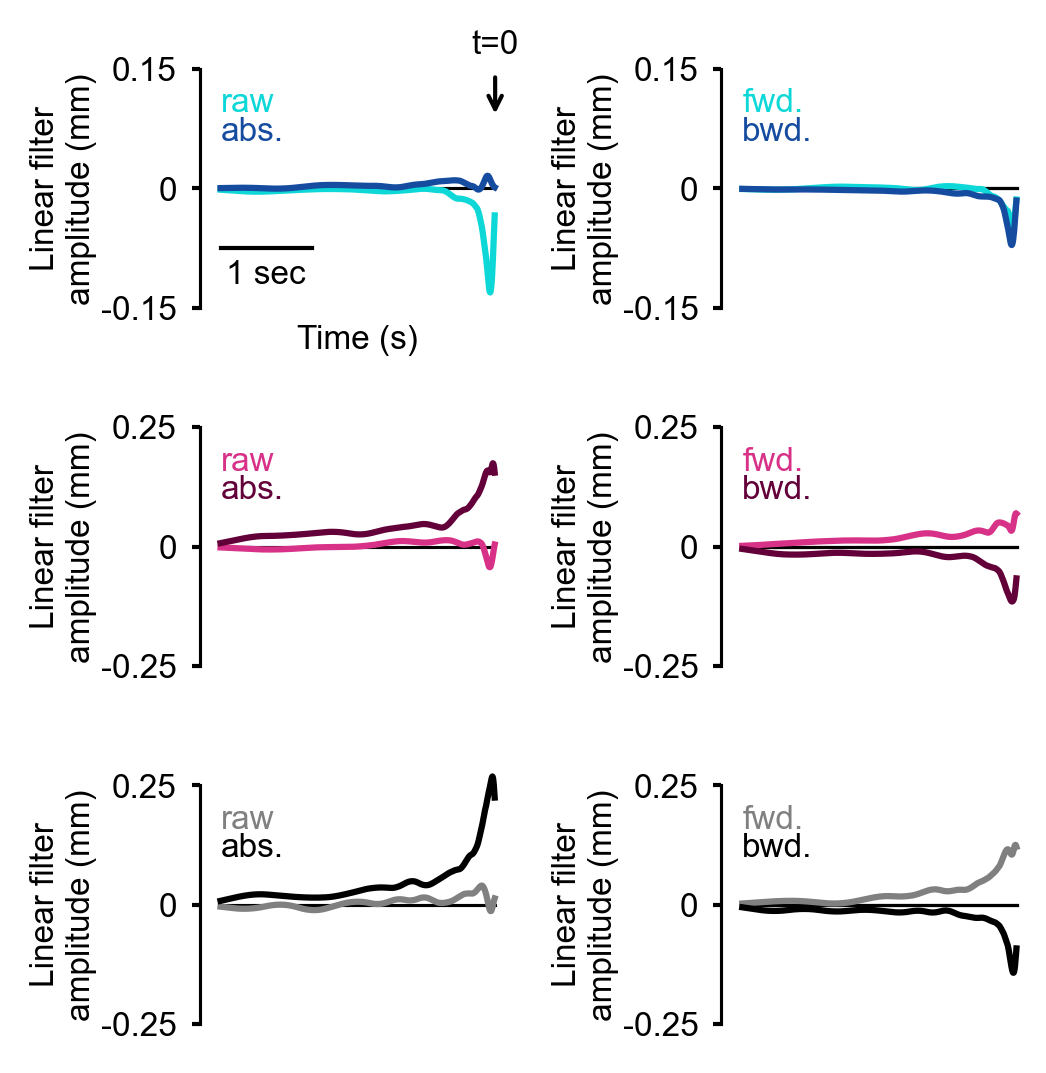

v_ang


C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\3139880473.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../fig/fig6_filters_{veltype}.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


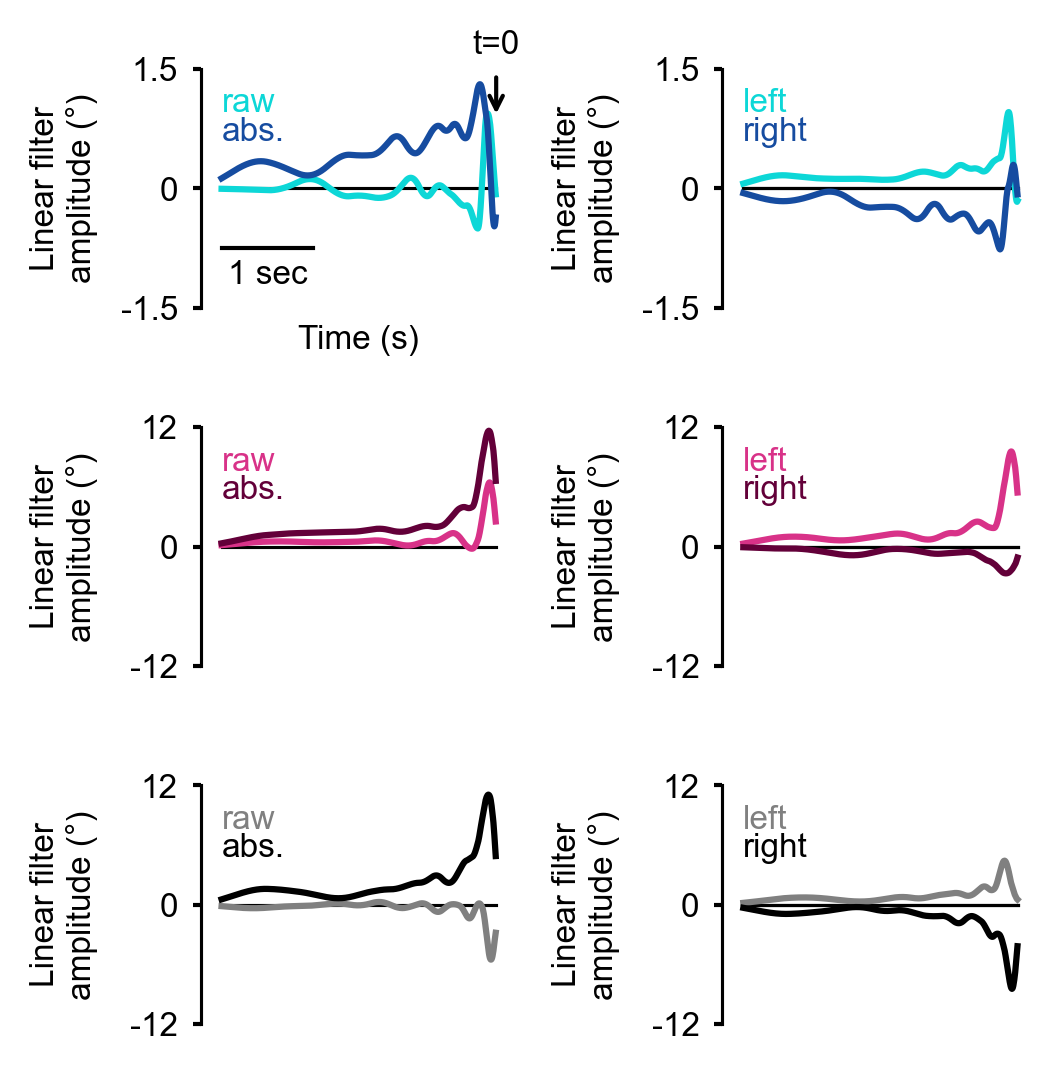

In [12]:
# filters out "undefined" side recordings, for a cleaner look at known-right or known-left in case of DopaMeander
filtered_df = df[~((df.DN == 'DopaMeander') & (df.side == 'undefined'))].copy()
# specifying temporarily neuron identity including side
filtered_df.loc[filtered_df.DN == 'DopaMeander','DN'] = filtered_df.loc[filtered_df.DN == 'DopaMeander','DN'] + ' ' + filtered_df.loc[filtered_df.DN == 'DopaMeander','side']

# plot order (top to bottom)
DN_list = ['MDN','DopaMeander left','DopaMeander right']

# plot parameters
variables_linestyle = ['solid','solid']
label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'fwd.','neg_v_fwd':'bwd.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'left','neg_v_ang':'right'}
ylabels = ['Linear filter\namplitude (mm)','Linear filter\namplitude (°)']
zerot_position = [0.15,1.5]
ylims_dict_dict = {'v_fwd':{'DopaMeander left': (-0.25,0.25),'DopaMeander right': (-0.25,0.25), 'MDN': (-0.15,0.15)}, 'v_ang':{'DopaMeander left': (-12,12), 'DopaMeander right': (-12,12), 'MDN': (-1.5,1.5)}}
DN_color_dict = {'MDN': ["#0DD7D7",'#164CA0'], 'DopaMeander left': ['#D83288', "#630039"], 'DopaMeander right': ["grey",'k']}
hspace = 0.5
wspace = 0.9
height_ratios = [1+hspace/3, 1+hspace/3, 1+hspace/3]
width_ratios = [1+wspace/2, 1+wspace/2]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# load estimated filters (generated by analysis.ipynb)
with open(f'{datefolder}/GLM_filters.pkl', 'rb') as handle:
    estimated_filters_dict = pickle.load(handle)

for iplot, veltype in enumerate(['v_fwd','v_ang']): # loop between translational and angular velocity data
    print(veltype)
    ylabel = ylabels[iplot]
    ylims_dict = ylims_dict_dict[veltype]
    fig,axes = plt.subplots(3,2,figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

    # plot for each variable
    for jv, variables_list in enumerate([[veltype,f'abs_{veltype}'],[f'pos_{veltype}',f'neg_{veltype}']]):
        for iDN, DN_type in enumerate(DN_list):
            ax = axes[iDN,jv]
            color_list = DN_color_dict[DN_type]

            # plot for each model
            for iv, varname in enumerate(variables_list):
                filename_list = filtered_df[(filtered_df.DN == DN_type)].filename.tolist()
                plot_glm_filter(ax=ax,estimated_filters_dict=estimated_filters_dict,filename_list=filename_list,varname=varname,T=T,main_color=color_list[iv],with_l2=False,with_individual_traces=False,linestyle=variables_linestyle[iv],lw=1.5,zero_line_lw=0)
                
            # limits, labels and ticks
            ylims = ylims_dict[DN_type]
            ax.set_ylim(ylims)
            ax.set_yticks([ylims[0],0,ylims[1]])
            ax.set_yticklabels([ylims[0],0,ylims[1]])
            ax.set_ylabel(ylabel)
            ax.yaxis.set_label_coords(-0.45, 0.5)
            ax.set_xlim([-3,0])
            ax.set_xticks([0,-3])
            # ax.set_xlabel('Time (s)',labelpad=0)
            ax.set_xlabel('')

            # manual legend text
            for iv, varname in enumerate(variables_list):
                ax.text(0,0.92-0.12*iv,label_dict[varname],transform=ax.transAxes,ha='left',va='top',color=color_list[iv])

            # scale bar
            if jv == 0 and iDN == 0:
                trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
                ax.plot([-3,-2],[0.25,0.25],lw=1,color='k',transform=trans)
                ax.text(-2.5,0.2,'1 sec',ha='center',va='top',transform=trans)

    # remove axis and adds zero line
    for ax in axes[:,1].flatten():
        ax.spines[['bottom','top','right','left']].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.axhline(0,lw=0.75,color='k',xmin=0,zorder=-1)
        ax.set_xlim([-3,0])

    # for ax in axes[:,0].flatten():
    for iDN, DN_type in enumerate(DN_list):
        for ii in range(2):
            ax = axes[iDN,ii]
            ylims = ylims_dict[DN_type]
            ax.spines['left'].set_visible(True)
            ax.spines[['bottom','top','right']].set_visible(False)
            ax.spines['left'].set_position(('outward', 5))
            ax.spines[['left']].set_bounds(ylims)
            ax.set_yticks([ylims[0],0,ylims[1]])
            ax.set_yticklabels([ylims[0],0,ylims[1]])
            ax.set_xticks([])
            ax.axhline(0,lw=0.75,color='k',xmin=0,zorder=-1)
            ax.set_xlim([-3,0])
            ax.set_xticks([])
    
    axes[0,0].set_xlabel('Time (s)')
    axes[0,0].annotate("t=0", xytext=(0, zerot_position[iplot]*1.2), xy=(0, zerot_position[iplot]/1.8), va='center', ha='center', arrowprops=dict(arrowstyle="->",linestyle='-'))
       

    # Fix for overlapping/occluded points in the negative values
    for o in fig.findobj():
        o.set_clip_on(False)
        
    plt.savefig(f'../fig/fig6_filters_{veltype}.pdf', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()

## Panels D,F,H,J (boxplots)

In [36]:
# def get_paired_arrays(df, cond1, cond2, value_col='pearsonr_score'):
#     a = df.query(cond1)[['unit_id', value_col]]
#     b = df.query(cond2)[['unit_id', value_col]]

#     paired = (
#         a.merge(b, on='unit_id', suffixes=('_a', '_b'))
#         .dropna()
#     )

#     return paired[value_col + '_a'].to_numpy(), paired[value_col + '_b'].to_numpy()
def get_paired_data(df, idx1, idx2, value_col='pearsonr_score'):
    a = df.loc[idx1, ['unit_id', value_col]]
    b = df.loc[idx2, ['unit_id', value_col]]

    paired = (
        a.merge(b, on='unit_id', suffixes=('_a', '_b'))
        .dropna()
    )

    return paired[f'{value_col}_a'].to_numpy(), paired[f'{value_col}_b'].to_numpy()

# def compare_pair(data_pair,verbose=False):
    
#     if np.any([shapiro(data_group).pvalue < 0.05 for data_group in data_pair]):
#         if verbose: print('using nonparam')
#         # p = mannwhitneyu(*data_pair,alternative='two-sided').pvalue
#         p = wilcoxon(*data_pair,alternative='two-sided').pvalue
        
#     else:
#         if verbose: print('using param')
#         # p = ttest_ind(*data_pair, equal_var=False).pvalue
#         p = ttest_rel(*data_pair, nan_policy='omit').pvalue
#     return p
def compare_pair(x, y, verbose=False):
    assert len(x) == len(y), "Paired arrays must have same length"

    if (shapiro(x).pvalue < 0.05) or (shapiro(y).pvalue < 0.05):
        if verbose:
            print('using wilcoxon')
        p = wilcoxon(x, y, alternative='two-sided', nan_policy='omit').pvalue
    else:
        if verbose:
            print(f'using ttest_rel {np.sum(~(np.isnan(x) | np.isnan(y)))} from {len(x)}')
        p = ttest_rel(x, y, nan_policy='omit').pvalue

    return p

C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\2650845755.py:57: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\2698417484.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_df = pd.concat((pv_df, pd.DataFrame([[pair[0], pair[1], panel_letters[iv], 'tbi', ps, corrected_ps]], columns=['Group 1', 'Group 2', 'Panel','Test','p','p (bonf corrected)'])))
C:\Users\apalaci\AppD

using wilcoxon
using ttest_rel 23 from 23
using ttest_rel 23 from 23
D (0, 2) 0.012294530868530273 0.03688359260559082
D (2, 3) 0.4764270491585153 1.429281147475546
D (1, 2) 0.1263752939637925 0.37912588189137747
using wilcoxon
using wilcoxon
using wilcoxon
F (0, 3) 4.76837158203125e-07 1.430511474609375e-06
F (1, 3) 8.845329284667969e-05 0.00026535987854003906
F (2, 3) 5.9604644775390625e-06 1.7881393432617188e-05
using ttest_rel 9 from 9
using ttest_rel 20 from 20
using wilcoxon
using ttest_rel 20 from 20
H (2, 4) 0.8596356066665253 3.438542426666101
H (3, 5) 0.00784966158867987 0.03139864635471948
H (0, 6) 0.00390625 0.015625
H (1, 7) 5.955546508696397e-09 2.3822186034785588e-08
using ttest_rel 9 from 9
using wilcoxon
using ttest_rel 9 from 9
using wilcoxon
J (2, 4) 0.010033756167570919 0.040135024670283674
J (3, 5) 0.011236471025746899 0.044945884102987596
J (0, 6) 0.004607370905624719 0.018429483622498875
J (1, 7) 5.7220458984375e-06 2.288818359375e-05


C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\2650845755.py:73: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=boxcolor_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8}, meanprops={"visible": False}, width=0.75) #, medianprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5})
C:\Users\apalaci\AppData\Local\Temp\ipykernel_16676\2650845755.py:89: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=True,

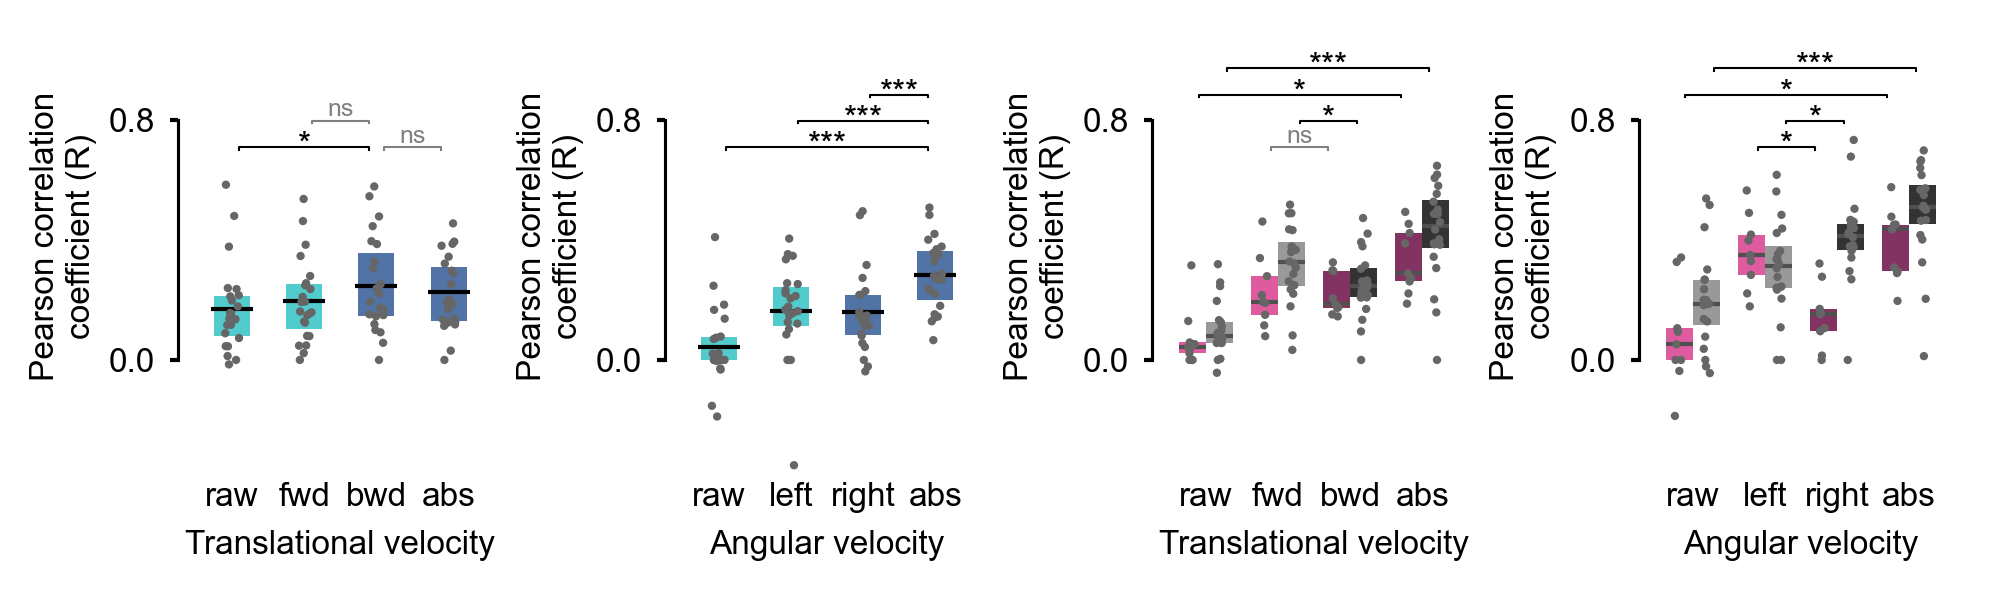

In [55]:
# load table of model performances (generated by analysis.ipynb)
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[~((df_plot.DN == 'DopaMeander') & (df_plot.DN_side == 'undefined'))].copy().reset_index(drop=True)
df_plot['unit_id'] = (df_plot['DN'].astype(str) + "_" + df_plot['filename'].astype(str))
df_plot['pearsonr_score'] = (df_plot['pearsonr_score'].astype(float).fillna(0.0))

# plot parameters
pairs_tested_list = [[(0,2),(2,3),(1,2)], [(0,3),(1,3),(2,3)], [(2,4),(3,5),(0,6),(1,7)], [(2,4),(3,5),(0,6),(1,7)]]
hlevels_list = [[0,0,1], [0,1,2], [0,1,2,3], [0,1,2,3]] # height for the p-value annotations
panel_letters = ['D','F','H','J'] # panel letter for the printing of values during the for-loop
ylims = [0,0.8]
hspace = 0
wspace = 0.5
height_ratios = [1.375]
width_ratios = [1.5+wspace/4, 1.5+wspace/4, 1.5+wspace/4, 1.5+wspace/4]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# Store p-values for table
pv_df = pd.DataFrame(columns=['Group 1', 'Group 2', 'Panel','Test','p','p (bonf corrected)'])

# plot
fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

# iterate per panel
for iv, DN, veltype, xlabel, pairs_tested, hlevels in zip(range(4),["MDN","MDN","DopaMeander","DopaMeander"],['v_fwd','v_ang','v_fwd','v_ang'],['Translational velocity','Angular velocity','Translational velocity','Angular velocity'],pairs_tested_list,hlevels_list):
    variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']
    grouped_idx = []

    ax = axes[iv]
    # distinct plot function and properties depending on neuron
    if DN == 'DopaMeander':
        stripcolor_palette = ["#D83288", "grey", "#D83288", "grey", "#630039", "k", "#630039", "k"]
        boxcolor_palette = ["#D83288", "#D83288", "#630039", "#630039", "grey", "grey", "k", "k"]
        _plot_bars_DM(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, stripcolor_palette=['#666666'],boxcolor_palette=boxcolor_palette,alpha_stripplot=1)

        # grouped_data = [df_plot[(df_plot.DN_side == hue)&(df_plot.DN == DN)&(df_plot.varname == varname)]['pearsonr_score'].tolist() for varname in variables_list for hue in ['left','right']]
        
        for varname in variables_list:
            for hue in ['left', 'right']:
                idx = (
                    (df_plot.DN == DN) &
                    (df_plot.varname == varname) &
                    (df_plot.DN_side == hue)
                )
                grouped_idx.append(idx)

        data_xpos = np.asarray([-0.2,0.2,0.8,1.2,1.8,2.2,2.8,3.2])
        hierarchy_shift = ylims[1]*0.11
        pv_line_min = ylims[1]*0.9
    elif DN == 'MDN':
        df_plot = df_plot.reset_index(drop=True)
        color_palette = MDN_colors
        _plot_bars(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, color_palette=color_palette,stripcolor_palette=['#666666'],alpha_stripplot=1)

        grouped_data = [df_plot[(df_plot.DN == DN)&(df_plot.varname == varname)]['pearsonr_score'].tolist() for varname in variables_list]

        for varname in variables_list:
            idx = (
                (df_plot.DN == DN) &
                (df_plot.varname == varname)
            )
            grouped_idx.append(idx)

        data_xpos = np.asarray([0,1,2,3])
        hierarchy_shift = ylims[1]*0.11
        pv_line_min = ylims[1]*0.85

    # p_array = np.asarray([compare_pair([grouped_data[igroup] for igroup in pair],verbose=True) for pair in pairs_tested])

    p_array = []
    for pair in pairs_tested:
        idx1, idx2 = pair
        x, y = get_paired_data(df_plot, grouped_idx[idx1], grouped_idx[idx2])

        if len(x) == 0:
            p_array.append(np.nan)
        else:
            p_array.append(compare_pair(x, y, verbose=True))

    p_array = np.asarray(p_array)

    corrected_p_array = p_array.shape[0]*p_array
    for pair, ps, corrected_ps in zip(pairs_tested, p_array, corrected_p_array):
        print(panel_letters[iv], pair, ps, corrected_ps)
        pv_df = pd.concat((pv_df, pd.DataFrame([[pair[0], pair[1], panel_letters[iv], 'tbi', ps, corrected_ps]], columns=['Group 1', 'Group 2', 'Panel','Test','p','p (bonf corrected)'])))
    add_pv_extra_explicit(corrected_p_array,grouped_data,data_xpos=data_xpos,pairs_tested=pairs_tested,hierarchy_levels=hlevels,hierarchy_shift=hierarchy_shift,pv_marker_width=ylims[1]*0.01,pv_line_min=0.7,ax=ax,numbers_fontsize=6,explicit_pvs=False,explicit_ns=False,asterisk_fontsize=8,ignore_ns=False,padding=0.1,line_lw=0.5)
    
    # ticks, labels and limits
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim([ylims[0]-0.15,ylims[1]+0.3])
    ax.spines[['left']].set_bounds(ylims)
    ax.set_xlim([-0.75,3.75])
    ax.spines['bottom'].set_position(('outward', 15))
    trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-0.2, (ylims[1]-ylims[0])/2,transform=trans)

# Fix for overlapping/occluded points in the negative values
for o in fig.findobj():
    o.set_clip_on(False)

for ax in axes.flatten():
    ax.set_ylabel('Pearson correlation\ncoefficient (R)')
    ax.yaxis.set_label_coords(-0.25, 0.45)

plt.savefig(f'../fig/fig6_panelDFHJ_boxplots.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Outliers in G and K
print(np.nanmin(df_plot[(df_plot.DN == 'MDN')&(df_plot.varname == 'pos_v_ang')]['pearsonr_score'].tolist()))
print(np.nanmin(df_plot[(df_plot.DN == 'DopaMeander')&(df_plot.varname == 'v_ang')]['pearsonr_score'].tolist()))

np.float64(-0.35079705972620856)

## Table of p-values for panels D,F,H,J

In [41]:
pv_df['Test'] = ['wilcoxon','ttest','ttest','ttest','wilcoxon','wilcoxon','wilcoxon','ttest','wilcoxon','ttest','ttest','wilcoxon','ttest','ttest']
pv_df.loc[pv_df['p (bonf corrected)']>1, 'p (bonf corrected)'] = 1
pv_df.reset_index(drop=True,inplace=True)

with pd.option_context('display.float_format', '{:.2e}'.format):
    print(pv_df)

   Group 1 Group 2 Panel      Test        p  p (bonf corrected)
0        0       2     D  wilcoxon 1.23e-02            3.69e-02
1        2       3     D     ttest 4.76e-01            1.00e+00
2        1       2     D     ttest 1.26e-01            3.79e-01
3        0       3     F     ttest 4.77e-07            1.43e-06
4        1       3     F  wilcoxon 8.85e-05            2.65e-04
5        2       3     F  wilcoxon 5.96e-06            1.79e-05
6        2       4     H  wilcoxon 8.60e-01            1.00e+00
7        3       5     H     ttest 7.85e-03            3.14e-02
8        0       6     H  wilcoxon 3.91e-03            1.56e-02
9        1       7     H     ttest 5.96e-09            2.38e-08
10       2       4     J     ttest 1.00e-02            4.01e-02
11       3       5     J  wilcoxon 1.12e-02            4.49e-02
12       0       6     J     ttest 4.61e-03            1.84e-02
13       1       7     J     ttest 5.72e-06            2.29e-05


## Table of variances for panels D,F,H,J

In [10]:
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[~((df_plot.DN == 'DopaMeander')&(df_plot.DN_side == 'undefined'))].reset_index(drop=True)

res = df_plot[(df_plot.DN.isin(['DopaMeander','MDN']))&(~df_plot.pearsonr_score.isna())].groupby(['DN','DN_side','varname'])['pearsonr_score'].agg(['mean','std']).reset_index().rename(columns={'DN':'Neuron','mean':'Average variance explained','DN_side':'Side','std':'Standard deviation'})

# renaming conventions (capitalize first letter, Trans/Ang and fwd/bwd/left/right)
res['Velocity'] = ['Translational' if 'fwd' in vv else 'Angular' for vv in res['varname']]
res.loc[res.Side == 'left','Side'] = 'Left'
res.loc[res.Side == 'right','Side'] = 'Right'
complist = []
for vv in res['varname']:
    if 'abs' in vv:
        complist.append('Absolute')
    elif 'neg' in vv:
        if 'fwd' in vv:
            complist.append('Backward')
        else:
            complist.append('Right')
    elif 'pos' in vv:
        if 'fwd' in vv:
            complist.append('Forward')
        else:
            complist.append('Left')
    else:
        complist.append('Unprocessed')
res['Component'] = complist
res = res[['Neuron','Side','Velocity','Component','Average variance explained','Standard deviation']]
res.set_index(['Neuron','Side','Velocity','Component']).sort_index(level=[0,1,2,3]).round(2)

Average variance explained  \
Neuron      Side      Velocity      Component                                 
DopaMeander Left      Angular       Absolute                           0.39   
                                    Left                               0.36   
                                    Right                              0.16   
                                    Unprocessed                        0.10   
                      Translational Absolute                           0.33   
                                    Backward                           0.22   
                                    Forward                            0.22   
                                    Unprocessed                        0.09   
            Right     Angular       Absolute                           0.49   
                                    Left                               0.34   
                                    Right                              0.43   
                                    Unprocessed                        0.21   
                      Translational Absolute                           0.45   
                                    Backward                           0.27   
                                    Forward                            0.32   
                                    Unprocessed                        0.11   
MDN         undefined Angular       Absolute                           0.28   
                                    Left                               0.19   
                                    Right                              0.17   
                                    Unprocessed                        0.06   
                      Translational Absolute                           0.24   
                                    Backward                           0.26   
                                    Forward                            0.20   
                                    Unprocessed                        0.18   

                                                 Standard deviation  
Neuron      Side      Velocity      Component                        
DopaMeander Left      Angular       Absolute                   0.12  
                                    Left                       0.12  
                                    Right                      0.10  
                                    Unprocessed                0.19  
                      Translational Absolute                   0.11  
                                    Backward                   0.07  
                                    Forward                    0.12  
                                    Unprocessed                0.10  
            Right     Angular       Absolute                   0.16  
                                    Left                       0.13  
                                    Right                      0.11  
                                    Unprocessed                0.16  
                      Translational Absolute                   0.13  
                                    Backward                   0.10  
                                    Forward                    0.13  
                                    Unprocessed                0.09  
MDN         undefined Angular       Absolute                   0.12  
                                    Left                       0.15  
                                    Right                      0.13  
                                    Unprocessed                0.15  
                      Translational Absolute                   0.11  
                                    Backward                   0.15  
                                    Forward                    0.13  
                                    Unprocessed                0.14

# Supplement figure 5

## Panels C-H (rolling correlations)

In [11]:
def rolling_window_traces(plot_df,reference,predicted,bins,rolling_window = 300,analysis_name='continuous_all'):
    analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
    idx_predicted = analysis_ynames.index(predicted)
    idx_reference = analysis_ynames.index(reference)
    
    final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2
    
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_m.pkl', 'rb') as handle:
        y_m_dict = pickle.load(handle)
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_pred.pkl', 'rb') as handle:
        y_pred_dict = pickle.load(handle)

    collected_traces = []
    for _, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
            rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan

    return final_bin_centers, stack_traces

2022_11_25_0009 may have constant prediction
2023_07_14_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_14760\3917152810.py:49: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_14760\3917152810.py:50: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
c:\mambaforge\envs\mdndm_env\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022_07_05_0010 may have constant prediction
2022_07_05_0011 may have constant prediction
2022_07_05_0013 may have constant prediction
2024_11_29_0001 may have constant prediction
2024_11_29_0001 may have constant prediction
2024_11_29_0001 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_14760\3917152810.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../fig/figS5_panelCtoH.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\mdndm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


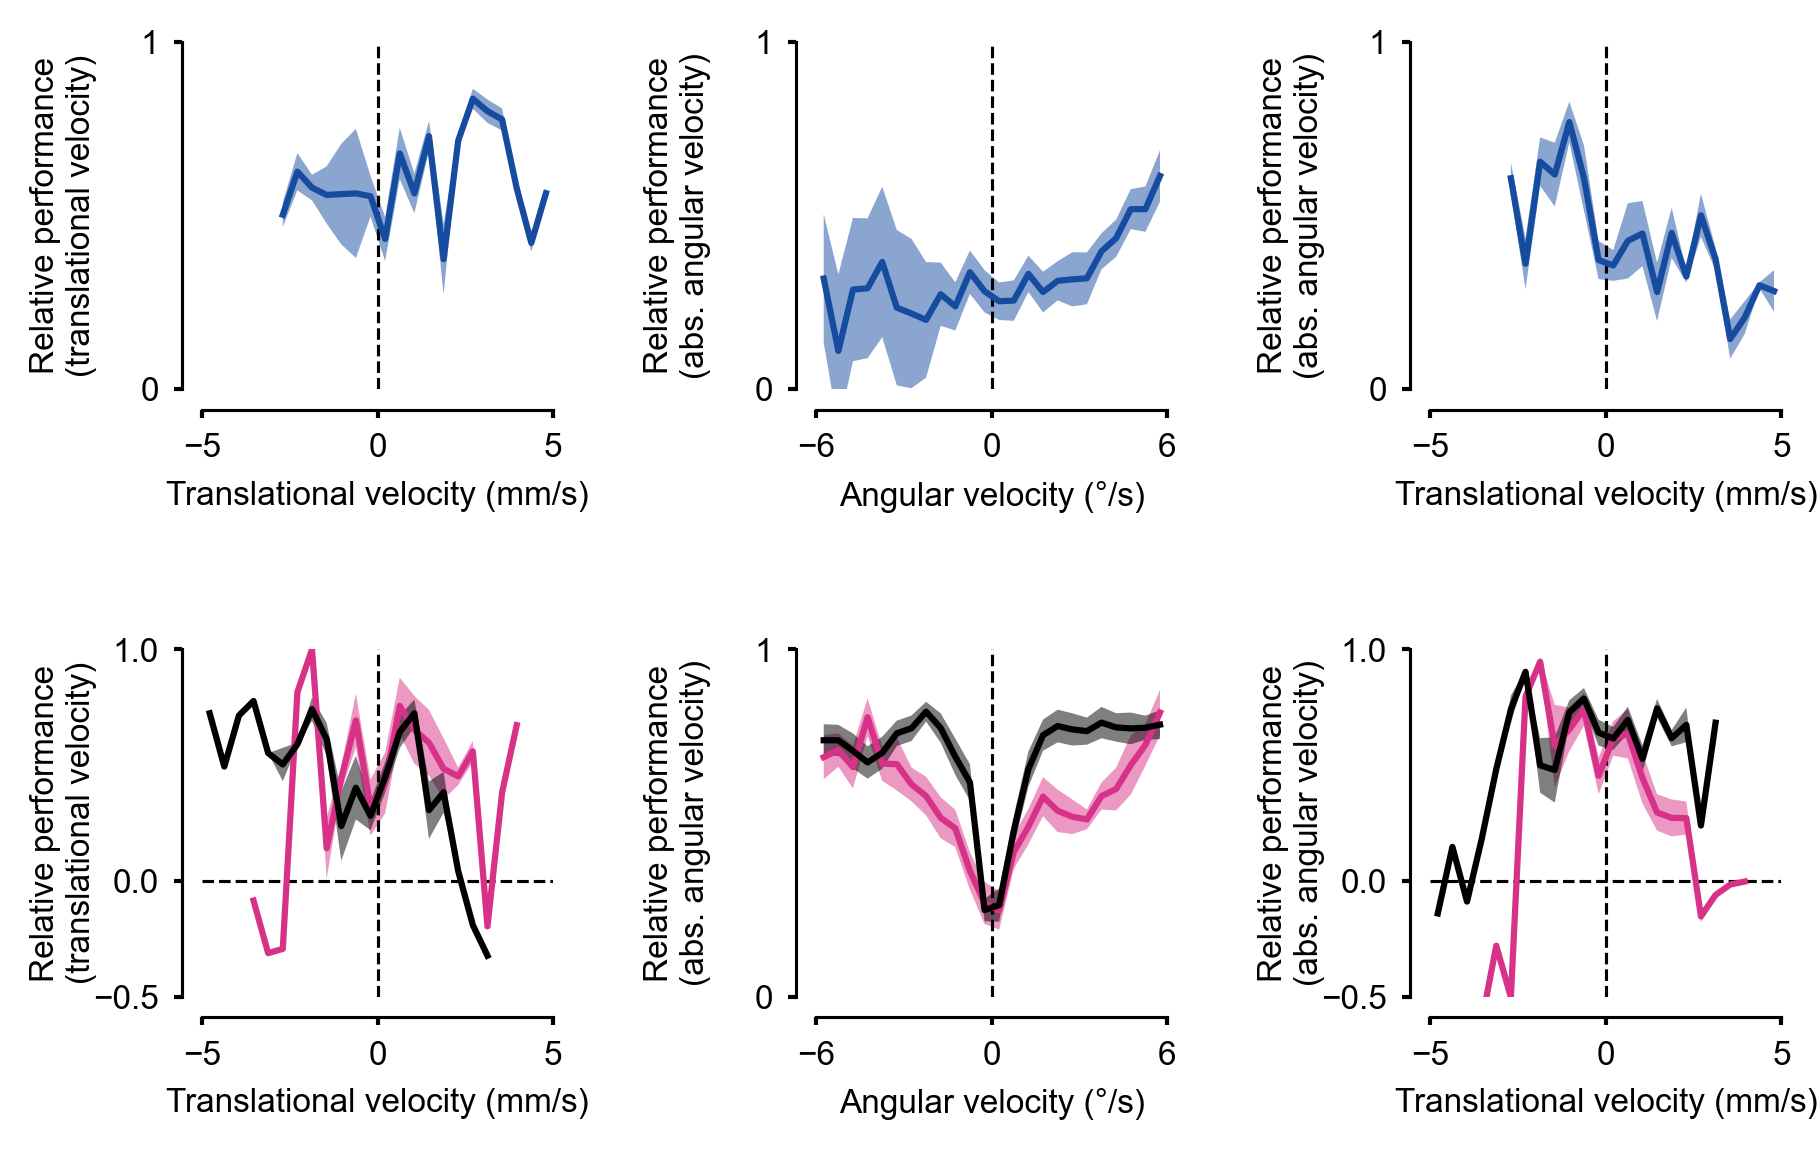

In [12]:
datadf_plot = df.copy()
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.side == 'undefined'))].reset_index(drop=True)

# plot parameters
normalize_traces = True
ylims = [0,1]
clip_on = True
rolling_window = 400
nbins = 25
hspace = 0.75
wspace = 0.75
nrows = 2
ncols = 3
height_ratios = [1+hspace/nrows]*nrows
width_ratios = [1+wspace/ncols]*ncols
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# panel details
panel_list = [
    ('MDN', 'v_fwd','v_fwd', 'Translational velocity (mm/s)', 'Relative performance\n(translational velocity)', (-5,5)),
    ('MDN', 'v_ang','abs_v_ang', 'Angular velocity (°/s)', 'Relative performance\n(abs. angular velocity)', (-6,6)),
    ('MDN', 'v_fwd','abs_v_ang', 'Translational velocity (mm/s)', 'Relative performance\n(abs. angular velocity)', (-5,5)),
    ('DopaMeander', 'v_fwd','v_fwd', 'Translational velocity (mm/s)', 'Relative performance\n(translational velocity)', (-5,5)),
    ('DopaMeander', 'v_ang','abs_v_ang', 'Angular velocity (°/s)', 'Relative performance\n(abs. angular velocity)', (-6,6)),
    ('DopaMeander', 'v_fwd','abs_v_ang', 'Translational velocity (mm/s)', 'Relative performance\n(abs. angular velocity)', (-5,5)),
    ]

# plot
fig, axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(0.5+sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
axes = axes.flatten()
for iax, (DN, ref_var, pred_var, xlabel, ylabel, xlims) in enumerate(panel_list):
    bins = np.linspace(xlims[0],xlims[1],nbins)
    ax = axes[iax]
    ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
    if DN == 'MDN':
        sides = ['undefined']
    else:
        sides = ['left','right']
    
    for side in sides:
        color = color_perside_dict[DN+' '+side]
        selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)

        try:
            final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference=ref_var,predicted=pred_var, bins = bins, rolling_window = rolling_window, analysis_name='continuous_NL_all')
            if normalize_traces:
                stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)
            ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
            ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        except ValueError:
            print('VALUE_ERROR, ', rolling_window, nbins)
            continue

    # general ticks and limits
    ax.set_xlim(xlims)
    ax.set_xticks([xlims[0],0,xlims[1]])
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.yaxis.set_label_coords(-0.3, 0.5)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))

# expand y-axis and add zero-line for panel F and H (bottom left and bottom right)
for iax in [3,5]:
    axes[iax].set_ylim([-0.5,1])
    axes[iax].set_yticks([-0.5,0,1])
    axes[iax].axhline(y=0,color='k',lw=0.75, linestyle='--',zorder=-1)

plt.savefig(f'../fig/figS5_panelCtoH.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()


## Panel A

C:\Users\apalaci\AppData\Local\Temp\ipykernel_27228\3119852267.py:29: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], edgecolor='none', ax=ax,alpha=1,dodge=True,legend=False, size=2, linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_27228\3119852267.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../fig/figS5_panelA.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


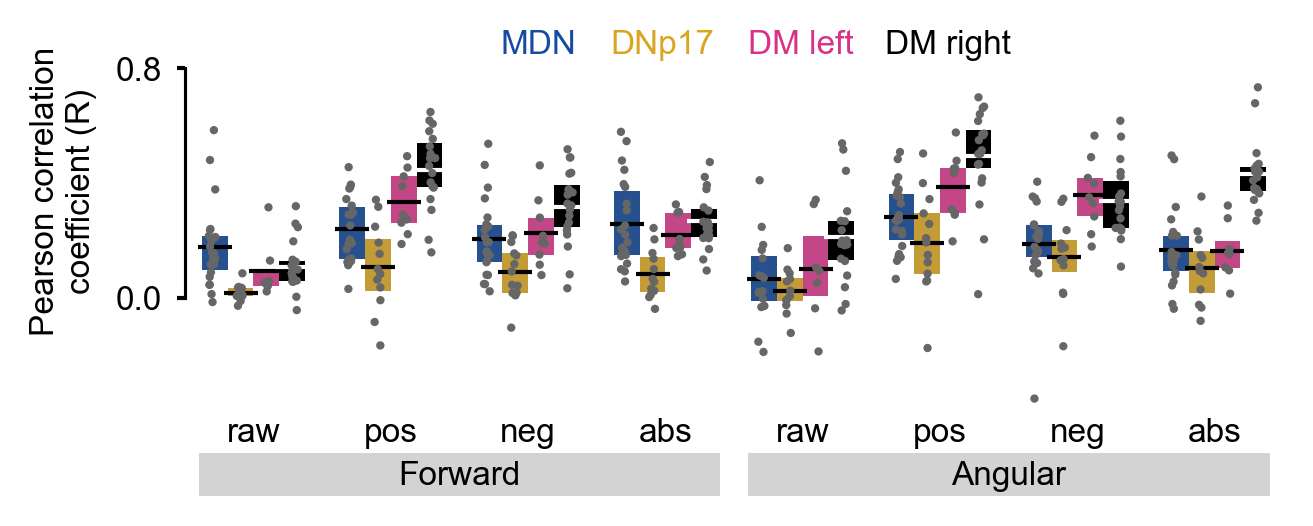

In [73]:
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)

# plot parameters
plot_variables_list = ['v_fwd','abs_v_fwd','pos_v_fwd','neg_v_fwd','v_ang','abs_v_ang','pos_v_ang','neg_v_ang']
plot_variables_labels =  ['raw','pos','neg','abs','raw','pos','neg','abs']
DN_list_order = ['MDN','DNp17','DopaMeander left','DopaMeander right']
ylims=[0,0.8]
height_ratios = [1]
width_ratios = [4]
wspace = 0.2
hspace = 0.2
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

# plot
fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)

# change mean line for dark groups
mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
for i, line in enumerate(mean_lines):
    if i>23:
        line.set_markerfacecolor('w')
        line.set_markeredgecolor('w')

# indidivual points
sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], edgecolor='none', ax=ax,alpha=1,dodge=True,legend=False, size=2, linewidth=0.5)

# ticks, limits and labels
ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='center',fontsize=8)
ax.tick_params(axis='x', which='major', length=0)
ax.set_yticks(ylims)
ax.add_patch(plt.Rectangle((-0.4,-0.69),3.8,0.15,facecolor='lightgrey',alpha=1,zorder=-1,clip_on=False))
ax.text(1.5,-0.65,'Forward',ha='center')
ax.add_patch(plt.Rectangle((3.6,-0.69),3.8,0.15,facecolor='lightgrey',alpha=1,zorder=-1,clip_on=False))
ax.text(5.5,-0.65,'Angular',ha='center')
ax.set_xlabel('')
ax.set_ylabel('Performance',fontsize=8)
trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-0.1, (ylims[1]-ylims[0])/2,transform=trans)
ax.spines['bottom'].set_visible(False)
ax.set_ylim([ylims[0]-0.15,ylims[1]])
ax.spines[['left']].set_bounds(ylims)
ax.spines['bottom'].set_position(('outward', 15))

# manual legend
for iDN, DN, DNname, xpos in zip(range(4), DN_list_order, ['MDN','DNp17','DM left', 'DM right'], [1,1.8,2.8,3.8]):
    ax.text(0.8+xpos,0.85,DNname,color=color_perside_dict[DN],fontsize=8)

# Fix for overlapping/occluded points in the negative values
for o in fig.findobj():
    o.set_clip_on(False)

ax.set_ylabel('Pearson correlation\ncoefficient (R)')
ax.yaxis.set_label_coords(-0.08, 0.55)

plt.savefig(f'../fig/figS5_panelA.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

## Panel B (residualization)  -  pending to implement in github, requires a full new analysis code, to be updated soon

In [14]:
# datefolder = f'{results_dir_path}/2025_glms_regressed_abs_v_fwd'
# df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
# df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
# df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
# df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)


# plot_variables_list = ['abs_v_fwd','abs_v_ang']
# plot_variables_labels = ['Trans.','Ang.']
# DN_list_order = ['MDN','DNp17','DopaMeander left','DopaMeander right']

# ylims=[-0.2,0.6]
# height_ratios = [1]
# width_ratios = [1]
# wspace = 0.2
# hspace = 0.2
# gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
# fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

# ax.axhline(y=0,color='k',lw=0.5,linestyle='--')

# sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"marker": "_", "markersize": 7, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
# mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
# for i, line in enumerate(mean_lines):
#     if i>5:
#         line.set_markerfacecolor('w')
#         line.set_markeredgecolor('w')

# sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=0.5,dodge=True,legend=False, size=2, edgecolor='none')

# ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='top')
# ax.set_xlabel('Abs. velocity')
# ax.set_ylabel('Cross-regressed\nperformance')

# ax.set_ylim([ylims[0]-0.15,ylims[1]])
# ax.set_yticks([ylims[0],0,ylims[1]])
# ax.spines['left'].set_position(('outward', 5))
# ax.spines['bottom'].set_position(('outward', -5))

# ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='center',fontsize=8)
# ax.tick_params(axis='x', which='major', length=0)

# ax.spines['bottom'].set_visible(False)
# ax.spines[['left']].set_bounds(ylims)

# trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
# ax.yaxis.set_label_coords(-0.4, (ylims[1]+ylims[0])/2,transform=trans)

# plt.savefig(f'fig/regressed_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()